In [78]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [79]:
#Restrict training to one gpu
import imp
try:
        imp.find_module('setGPU')
        import setGPU
except ImportError:
        found = False
#/////////////////////
import h5py
import matplotlib
import tensorflow as tf
sess = tf.Session()
import matplotlib.pyplot as plt
import keras.backend as K
K.set_session(sess)
import pylab as P
import pandas as pd
import numpy as np
import keras.callbacks
import glob
import math

#Useful sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

#Keras model related imports
from keras.models import Model
from keras.layers import Input,Dense,Conv1D,LSTM,Flatten,Dropout,Activation,BatchNormalization
from keras.layers.advanced_activations import PReLU, LeakyReLU
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from keras.callbacks import Callback
from keras.models import load_model

#For training progress bar to display correctly
#see: https://github.com/bstriner/keras-tqdm/blob/master/examples/keras_progress_bars.ipynb
from keras_tqdm import TQDMNotebookCallback


In [80]:
extended = True

# dataFile = '/Users/innocent/data/clusterShapePU50Ideal.csv'
# name = 'clusElipseKerasPU50IdealL'

# dataFile ="/Users/innocent/data/clusterShapePU50.csv"
# name = 'clusElipseKerasPU50'

dataFile ="/Users/innocent/data/clusterShape2.csv"


# name = 'clusElipseKeras2'

name = 'clusElipseKerasZ' if extended else 'clusElipseKeras2'


loadIt = False # True # False #

In [81]:
#/////Reading the data
#/////////////////////
clusAll = np.genfromtxt(dataFile, delimiter=" ", skip_header=0, names=True)
clusAll['l2'] = np.nan_to_num(clusAll['l2'])
print clusAll.shape

(2006835,)


In [82]:
n = clusAll.dtype.names
print n
i_train = np.genfromtxt(dataFile, delimiter=" ",\
                       skip_header=1, dtype='<f4',
                       usecols=(n.index('isBarrel'), n.index('layer'), n.index('x'),n.index('y'),
#                                n.index('xx'), n.index('yy'), n.index('xy'),
                                n.index('dx'), n.index('dy'), n.index('l2'),
                                n.index('sx'), n.index('sy'), n.index('z')# n.index('s'), n.index('q')
                                )
                        )

y_train = np.genfromtxt(dataFile, delimiter=" ",\
                       skip_header=1,dtype='<f4',
                       usecols=(n.index('simSX'), n.index('simSY'))
                       )

('isBarrel', 'layer', 'z', 'simX', 'simY', 'simSX', 'simSY', 'recX', 'recY', 'tkSX', 'tkSY', 'x', 'y', 'xx', 'yy', 'xy', 'dx', 'dy', 'l2', 'sx', 'sy', 's', 'q')


In [83]:
i_train = np.nan_to_num(i_train)
print i_train.shape

i_train[:,9] = np.where(i_train[:,0]==1, 0, i_train[:,9])
if extended :
  addOn = np.zeros((i_train.shape[0],10),dtype='<f4')
  print addOn.shape, addOn.dtype
  layer = np.array(i_train[:,1]+6*i_train[:,0]-1,dtype=int)
  layer = np.where(i_train[:,9]==1, layer+3, layer)
  print layer.shape, layer.dtype
  print layer[0]
  # for j in xrange(0,i_train.shape[0]) : addOn[j,layer[j]] = 1
  addOn[np.arange(layer.shape[0]),layer] =1
  print addOn[0]
  x_train = np.hstack((i_train,addOn))
else :
  x_train = i_train
  print x_train.shape


(2006835, 10)
(2006835, 10) float32
(2006835,) int64
6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [84]:
x_train[:,2] = x_train[:,2]/x_train[:,7]
x_train[:,3] = x_train[:,3]/x_train[:,8]

In [85]:
xw=2
x_train[:,4] = xw*x_train[:,4]
x_train[:,7] = xw*x_train[:,7]
y_train[:,0] = xw*y_train[:,0]

In [86]:
y_train[:,0] = np.where(x_train[:,8]>1, y_train[:,0], np.abs(y_train[:,0]) )
y_train[:,0] = y_train[:,0] - x_train[:,4]
y_train[:,1] = y_train[:,1] - x_train[:,5]

In [87]:
print x_train.dtype
print x_train.shape
print y_train.dtype.names
print x_train.size
print x_train[0]

print y_train.dtype.names
print y_train.shape
print x_train.size
print y_train[0]

float32
(2006835, 20)
None
40136700
[ 1.          1.          0.3072535   0.45147642 -3.33742    13.9189
  1.00999     4.         14.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
None
(2006835, 2)
40136700
[2.0789518  0.09520054]


In [88]:
x_test = x_train[x_train.shape[0]/2:,:]
print x_test.dtype
print x_test.shape
print x_test.dtype.names
print x_test.size
print x_test[0]

y_test = y_train[y_train.shape[0]/2:,:]
print y_test.dtype.names
print y_test.shape
print y_test.size
print y_test[0]


clus = clusAll[clusAll.shape[0]/2:]
print clus.shape
print clus[0]

float32
(1003418, 20)
None
20068360
[1.        3.        0.430971  0.5502225 2.02246   3.69938   0.973263
 4.        4.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        1.        0.       ]
None
(1003418, 2)
2006836
[-1.63205   -0.3900199]
(1003418,)
(1., 3., 1., 0.789416, -2.5716, 0.195205, 3.30936, 0.787379, -2.57545, 0.206086, 3.30129, 0.861942, 2.20089, 0.118998, 0.859455, 0.218749, 1.01123, 3.69938, 0.973263, 2., 4., 5., 63220.)


In [89]:
#weights_ = np.ones(x_train.shape[0])
weights_ = np.sqrt(np.maximum(x_train[:,8],x_train[:,7]))
# weights_ *= 1+np.equal(x_train[:,1],1)*np.equal(x_train[:,0],1)

In [90]:
dropoutRate_=0.2
reg_rate_=0.00
loss_ = 'mse' #'mse','binary_crossentropy','mae'
Nepoch_=40
batch_size_=512
adam_=optimizers.Nadam(lr=0.001) # 001)
reduce_lr_ = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0.00001)
earlyStop_ = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5)
act = 'linear' #'relu'   #'sigmoid' 'relu' 'linear'

In [91]:
def mylayer(a,n=1) :
    a = Dense(n*64,activation=act, 
              kernel_initializer='glorot_uniform', #'normal',
              bias_initializer='normal',
              kernel_regularizer=l2(reg_rate_))(a)
    a = PReLU()(a) # LeakyReLU(alpha=0.3)(a) #PReLU()(a)
    a = Dropout(dropoutRate_)(a)
    # a = BatchNormalization()(a)
    return a;

In [116]:
#/////Better metrics to monitor while training
#/////////////////////////////////////////////
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print " — val_f1: %f — val_precision: %f — val_recall %f " %(_val_f1, _val_precision, _val_recall)
        return
 
metrics_ = Metrics()

#/////Creating the model
#//////////////////////

a_inp = Input(shape=(x_train.shape[1],),name='ins')
a = BatchNormalization()(a_inp)
a = mylayer(a,4)
a = mylayer(a,2)
a = mylayer(a,2)
a = mylayer(a)
a = mylayer(a)
a_out = Dense(2, activation='linear', kernel_initializer='normal', name='outs')(a)


model= load_model(name+'Dim.h5') if loadIt else Model(inputs=a_inp,outputs=a_out)
if (not loadIt) :
    model.compile(loss=loss_, optimizer=adam_,
                  metrics=['acc']) # ,'mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ins (InputLayer)             (None, 20)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dense_31 (Dense)             (None, 256)               5376      
_________________________________________________________________
p_re_lu_31 (PReLU)           (None, 256)               256       
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
p_re_lu_32 (PReLU)           (None, 128)               128       
__________

In [117]:
#//////Train the model
#/////////////////////

#NOTE: Due to some unfortunate incompability with the notebooks and keras,
#displaying the progress of training requires additional effort, i.e.
#TQDMNotebookCallback or something similar. This however interferes with
#printing the custom monitoring metrics at the end of epoch. They will
#show correctly after the training finishes.
if (not loadIt) :
    history=model.fit(x_train,y_train,
        epochs=Nepoch_,
        batch_size=batch_size_,
        sample_weight=weights_,
        callbacks=[reduce_lr_,earlyStop_],
#        callbacks=[reduce_lr_,metrics_,TQDMNotebookCallback(metric_format="{name}: {value:0.6f}")],
        validation_split=0.5,
        shuffle=True,
        verbose=1)
    model.save(name+'Dim.h5')

Train on 1003417 samples, validate on 1003418 samples
Epoch 1/40
1003417/1003417 [==============================] - 25s 25us/step - loss: 1.1020 - acc: 0.8575 - val_loss: 0.9335 - val_acc: 0.8664
Epoch 2/40
1003417/1003417 [==============================] - 24s 24us/step - loss: 1.0051 - acc: 0.8624 - val_loss: 0.9028 - val_acc: 0.8682
Epoch 3/40
1003417/1003417 [==============================] - 25s 25us/step - loss: 0.9866 - acc: 0.8632 - val_loss: 0.9058 - val_acc: 0.8701
Epoch 4/40
1003417/1003417 [==============================] - 25s 25us/step - loss: 0.9775 - acc: 0.8639 - val_loss: 0.9086 - val_acc: 0.8719
Epoch 5/40
1003417/1003417 [==============================] - 26s 26us/step - loss: 0.9716 - acc: 0.8643 - val_loss: 0.8935 - val_acc: 0.8697
Epoch 6/40
1003417/1003417 [==============================] - 27s 26us/step - loss: 0.9665 - acc: 0.8647 - val_loss: 0.8859 - val_acc: 0.8703
Epoch 7/40
1003417/1003417 [==============================] - 26s 26us/step - loss: 0.9608 - a

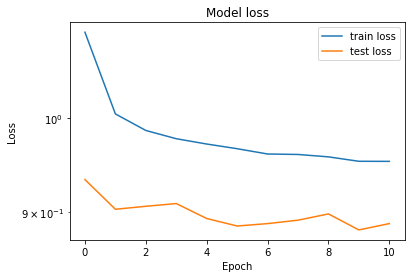

In [118]:
if (not loadIt) :
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.legend(['train loss', 'test loss','test f1'])
    plt.show()
    #plt.savefig('Training_losses.pdf')


In [119]:
#plt.plot(metrics_.val_f1s)
#plt.plot(metrics_.val_recalls)
#plt.plot(metrics_.val_precisions)
#plt.title('Metrics')
#plt.ylabel('Value')
#plt.xlabel('Epoch')
#plt.legend(['F1','Recall','Precision'])
#plt.savefig('Metrics.pdf')

In [120]:
y_pred = model.predict(x_test)
print y_pred.shape

(1003418, 2)


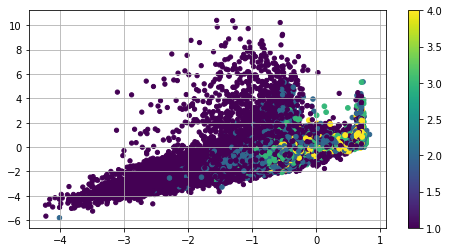

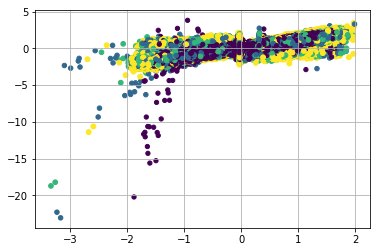

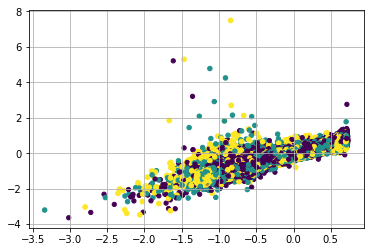

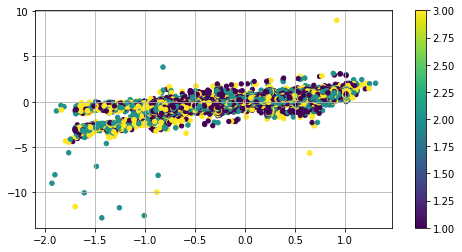

In [121]:
lb = np.ma.masked_where(clus['isBarrel']==0,2*clus['layer']+16)
le = np.ma.masked_where(clus['isBarrel']==1,2*clus['layer']+16)
# nn = np.ma.masked_where(np.logical_or(clus['simSY']<5,clus['dy']<clus['simSY']),clus['layer']+1)
plt.figure(figsize=(8, 4))
plt.scatter(y_pred[:,1],y_test[:,1],s=lb,marker='o',c=clus['layer'])
plt.colorbar()
plt.grid()
plt.show()
plt.scatter(y_pred[:,0]/xw,y_test[:,0]/xw,s=lb,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(y_pred[:,1],y_test[:,1],s=le,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.figure(figsize=(8, 4))
plt.scatter(y_pred[:,0]/xw,y_test[:,0]/xw,s=le,marker='o',c=clus['layer'])
plt.colorbar()
plt.grid()
plt.show()

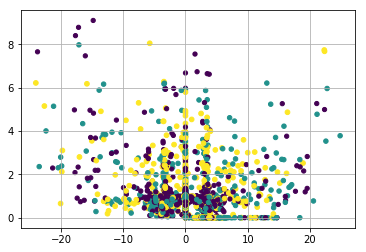

In [122]:
xe = np.abs(y_pred[:,0]/xw-y_test[:,0]/xw)
xe1 = np.logical_or(np.greater(xe,1.5),np.less(xe,0.5))
le1 = np.ma.masked_where(np.logical_or(xe1,clus['isBarrel']==1),2*clus['layer']+16)
#plt.scatter(xe,x_test[:,4]/xw,s=le1,marker='o',c=clus['layer'])
plt.scatter(x_test[:,4],x_test[:,5]/xw,s=le1,marker='o',c=clus['layer'])
plt.grid()
plt.show()

In [123]:
def hist(w) :
    nbins = 100
    y1,xy = np.histogram(y_pred[:,1]-y_test[:,1],np.linspace(-4.,4.,nbins),weights=w, density=True)
    y2,xy = np.histogram(y_pred[:,0]/xw-y_test[:,0]/xw,np.linspace(-4.,4.,nbins),weights=w, density=True)
    xy.resize(len(y2))
    return xy,y1,y2

In [124]:
isS2 = np.equal(clus['sx'],2)*np.greater(clus['x'],0.5)
isl1 = np.equal(clus['layer'],1)
notl1 = np.logical_not(isl1)
notS1 = np.greater(clus['s'],1)
isS1 = np.equal(clus['sx'],1)
xy,y1,y2 = hist(clus['isBarrel']) # *notS1) # *isl1)
exy,ey1,ey2 = hist((1-clus['isBarrel'])) # *notS1)  # *isl1)                                    

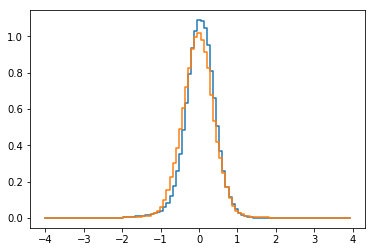

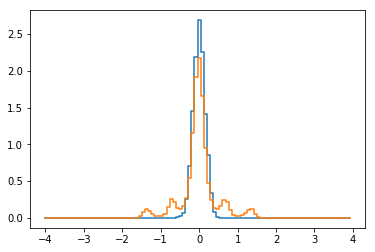

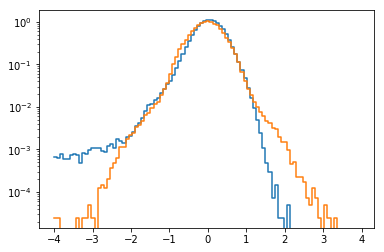

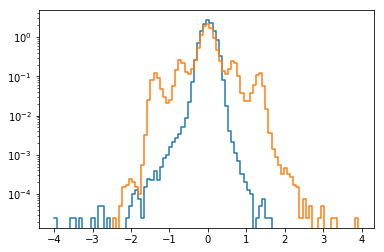

In [125]:
plt.step(xy,y1,where='post')
plt.step(xy,y2,where='post')
plt.show()
plt.step(exy,ey1,where='post')
plt.step(exy,ey2,where='post')
plt.show()

plt.yscale('log')
plt.step(xy,y1,where='post')
plt.step(xy,y2,where='post')
plt.show()
plt.yscale('log')
plt.step(exy,ey1,where='post')
plt.step(exy,ey2,where='post')
plt.show()

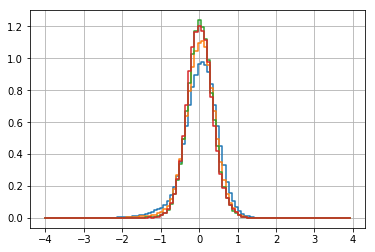

In [126]:
isl1 = np.equal(clus['layer'],1)
isl2 = np.equal(clus['layer'],2)
isl3 = np.equal(clus['layer'],3)
isl4 = np.equal(clus['layer'],4)
isB = clus['isBarrel']
nbins = 100
def plBL(w) :
  y1,xy = np.histogram(y_pred[:,1]-y_test[:,1],np.linspace(-4.,4.,nbins),weights=isB*w, density=True)
  xy.resize(len(y1))
  plt.step(xy,y1,where='post')

plBL(isl1)
plBL(isl2)
plBL(isl3)
plBL(isl4)
plt.grid()
plt.show()


In [140]:
s_inp = Input(shape=(x_train.shape[1],),name='ins')
a = BatchNormalization()(s_inp)
a = mylayer(a,4)
a = mylayer(a,2)
a = mylayer(a,2)
a = mylayer(a)
a = mylayer(a)
s_out = Dense(2, activation='linear', kernel_initializer='normal',name='outs')(a)

modelS = load_model(name+'Sigma.h5') if loadIt else Model(inputs=s_inp,outputs=s_out)
if (not loadIt) :
    modelS.compile(loss=loss_, optimizer=adam_,metrics=['acc']) # ,'mae'])
modelS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ins (InputLayer)             (None, 20)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
dense_41 (Dense)             (None, 256)               5376      
_________________________________________________________________
p_re_lu_41 (PReLU)           (None, 256)               256       
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
p_re_lu_42 (PReLU)           (None, 128)               128       
__________

In [141]:
#print x_train.shape
y_pred0 = model.predict(x_train)
s_train = np.empty_like(y_train)
#s_train[:,0] = y_pred0[:,0]/xw-y_train[:,0]/xw
#s_train[:,1] = y_pred0[:,1]-y_train[:,1]
s_train[:,0] = np.abs(y_pred0[:,0]/xw-y_train[:,0]/xw)
s_train[:,1] = np.abs(y_pred0[:,1]-y_train[:,1])
#isBL1 = np.logical_and(np.equal(x_train[:,0],1),np.equal(x_train[:,1],1))
#print isBL1.shape
#s_train[:,1] = np.where(isBL1,np.abs(y_pred0[:,1]-y_train[:,1]-0.85),s_train[:,1])
s_test = s_train[s_train.shape[0]/2:,:]
print s_test.shape

(1003418, 2)


In [142]:
if (not loadIt) :
    historyS=modelS.fit(x_train,s_train,
        epochs=Nepoch_,
        batch_size=batch_size_,
        sample_weight=weights_,
        callbacks=[reduce_lr_,earlyStop_],
#        callbacks=[reduce_lr_,metrics_,TQDMNotebookCallback(metric_format="{name}: {value:0.6f}")],
        validation_split=0.5,
        shuffle=True,
        verbose=1)
    modelS.save(name+'Sigma.h5')

Train on 1003417 samples, validate on 1003418 samples
Epoch 1/40
1003417/1003417 [==============================] - 24s 24us/step - loss: 0.1328 - acc: 0.5911 - val_loss: 0.1282 - val_acc: 0.6066
Epoch 2/40
1003417/1003417 [==============================] - 23s 23us/step - loss: 0.1286 - acc: 0.5973 - val_loss: 0.1263 - val_acc: 0.5997
Epoch 3/40
1003417/1003417 [==============================] - 24s 24us/step - loss: 0.1275 - acc: 0.5992 - val_loss: 0.1258 - val_acc: 0.6010
Epoch 4/40
1003417/1003417 [==============================] - 24s 24us/step - loss: 0.1270 - acc: 0.6008 - val_loss: 0.1258 - val_acc: 0.6076
Epoch 5/40
1003417/1003417 [==============================] - 24s 24us/step - loss: 0.1258 - acc: 0.6007 - val_loss: 0.1259 - val_acc: 0.5994
Epoch 6/40
1003417/1003417 [==============================] - 24s 24us/step - loss: 0.1253 - acc: 0.6017 - val_loss: 0.1246 - val_acc: 0.6010


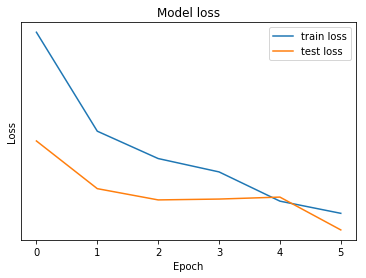

In [143]:
if (not loadIt) :
    plt.plot(historyS.history['loss'])
    plt.plot(historyS.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.legend(['train loss', 'test loss','test f1'])
    plt.show()
    #plt.savefig('Training_losses.pdf')


In [144]:
s_pred = modelS.predict(x_test)
print s_pred.shape

(1003418, 2)


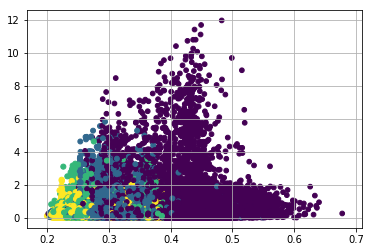

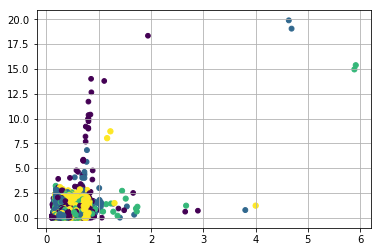

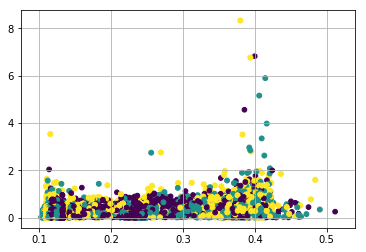

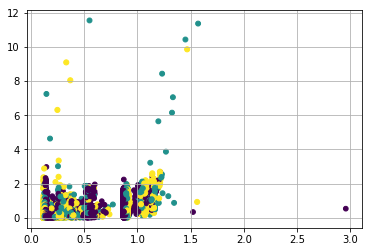

In [145]:
lb = np.ma.masked_where(clus['isBarrel']==0,2*clus['layer']+20)
le = np.ma.masked_where(clus['isBarrel']==1,2*clus['layer']+20)
# nn = np.ma.masked_where(np.logical_or(clus['simSY']<5,clus['dy']<clus['simSY']),clus['layer']+1)
plt.scatter(s_pred[:,1],s_test[:,1],s=lb,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(s_pred[:,0],s_test[:,0],s=lb,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(s_pred[:,1],s_test[:,1],s=le,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(s_pred[:,0],s_test[:,0],s=le,marker='o',c=clus['layer'])
plt.grid()
plt.show()

In [146]:
def hist(w) :
    nbins = 100
    y1,xy = np.histogram(clus['dy']+y_pred[:,1]-clus['simSY'],np.linspace(-4.,4.,nbins),weights=w, density=True)
    sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-4.,4.,nbins),weights=w, density=True)
    xy.resize(len(y1))
    x1,xx = np.histogram(clus['dx']+y_pred[:,0]/xw-clus['simSX'],np.linspace(-4.,4.,nbins),weights=w, density=True)
    sx,xx = np.histogram((clus['dx']+y_pred[:,0]/xw-clus['simSX'])/s_pred[:,0],np.linspace(-4.,4.,nbins),weights=w,density=True)
    xx.resize(len(x1))
    return xy,y1,sy,xx,x1,sx


In [147]:
def plotHF(w)  :
  nbins = 100
  isl1 = np.equal(clus['layer'],1)
  isl2 = np.equal(clus['layer'],2)
  isl3 = np.equal(clus['layer'],3)
  isl4 = np.equal(clus['layer'],4)
  isVVLong = np.greater(clus['sy'],12)
  isVLong = np.greater(clus['sy'],8)
  isLong = np.greater(clus['sy'],4)
  isShort = np.less(clus['sy'],5)

  sy,xy = np.histogram(((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1]),np.linspace(-5.,4.,nbins),weights=w*isl1, density=True) 
  xy.resize(len(sy))
  plt.step(xy,sy,where='post')
  sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-5.,4.,nbins),weights=w*isl2, density=True) 
  xy.resize(len(sy))
  plt.step(xy,sy,where='post')
  sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-5.,4.,nbins),weights=w*isl3, density=True) 
  xy.resize(len(sy))
  plt.step(xy,sy,where='post')
  sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-5.,4.,nbins),weights=w*isl4, density=True) 
  xy.resize(len(sy))
  plt.step(xy,sy,where='post')
  plt.grid()
  plt.show()

  isl1 = np.equal(clus['layer'],1)
  #plt.yscale('log')

  sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-5.,4.,nbins),weights=w*isl1*isShort, density=True) 
  xy.resize(len(sy))
  plt.step(xy,sy,where='post')
  sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-5.,4.,nbins),weights=w*isl1*isLong, density=True) 
  xy.resize(len(sy))
  plt.step(xy,sy,where='post')
  sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-5.,4.,nbins),weights=w*isl1*isVLong, density=True) 
  xy.resize(len(sy))
  plt.step(xy,sy,where='post')
  sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-5.,4.,nbins),weights=w*isl1*isVVLong, density=True) 
  xy.resize(len(sy))
  plt.step(xy,sy,where='post')


  plt.grid()
  plt.show()



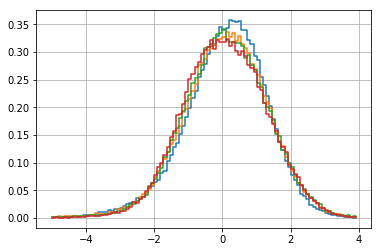

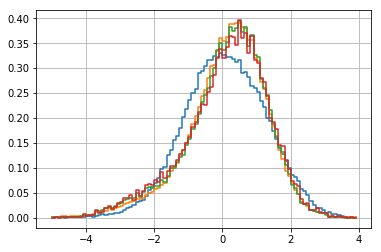

In [148]:
plotHF(clus['isBarrel'])
       

In [149]:
nbins = 100
isS2 = np.equal(clus['sx'],2)*np.greater(clus['x'],0.5)
isl1 = np.equal(clus['layer'],1)
isl2 = np.equal(clus['layer'],2)
isl3 = np.equal(clus['layer'],3)
isl4 = np.equal(clus['layer'],4)
notl1 = np.logical_not(isl1)
notS1 = np.greater(clus['s'],1)
isVLong = np.greater(clus['sy'],12)
isELong = np.greater(clus['sy'],3)
isLong = np.equal(clus['sy'],3)
isShort = np.less(clus['sy'],3)
ok = np.less(clus['l2'],10.)
xy,y1,sy,xx,x1,sx = hist((clus['isBarrel'])) # *isl1))
sxy,sy1,ssy,sxx,sx1,ssx = hist((clus['isBarrel'])*isShort) # *isl1)
lxy,ly1,lsy,lxx,lx1,lsx = hist((clus['isBarrel'])*isELong) # *isl1)
vxy,vy1,vsy,vxx,vx1,vsx = hist((clus['isBarrel'])*isVLong) # *isl1)
exy,ey1,esy,exx,ex1,esx = hist((1-clus['isBarrel'])) # *isl1)
esxy,esy1,essy,esxx,esx1,essx = hist((1-clus['isBarrel'])*isShort) # *isl1)
elxy,ely1,elsy,elxx,elx1,elsx = hist((1-clus['isBarrel'])*isLong) # *isl1)
eexy,eey1,eesy,eexx,eex1,eesx = hist((1-clus['isBarrel'])*isELong) # *isl1)

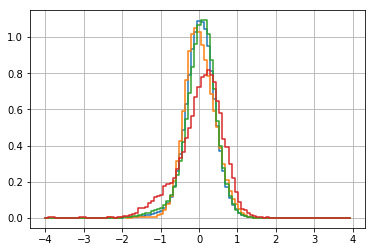

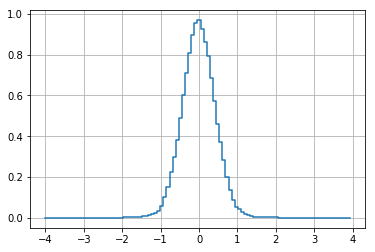

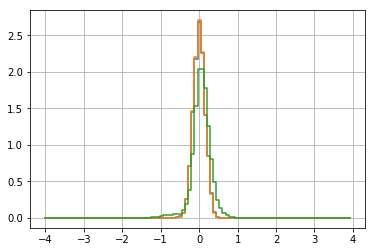

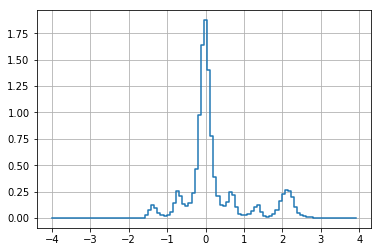

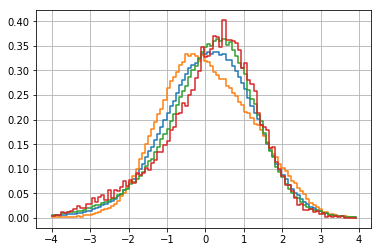

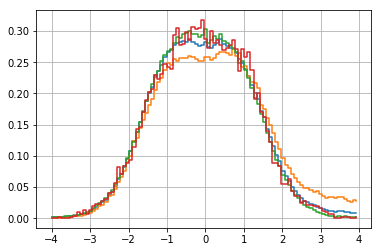

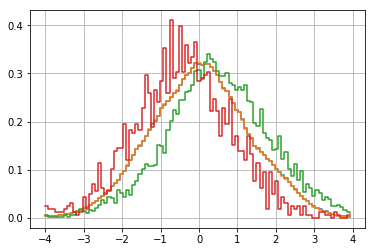

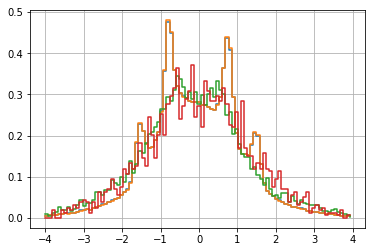

In [150]:
plt.step(xy,y1,where='post')
plt.step(sxy,sy1,where='post')
plt.step(lxy,ly1,where='post')
plt.step(vxy,vy1,where='post')
plt.grid()
plt.show()
plt.step(xx,x1,where='post')
plt.grid()
plt.show()
plt.step(exy,ey1,where='post')
plt.step(esxy,esy1,where='post')
plt.step(elxy,ely1,where='post')
plt.grid()
plt.show()
plt.step(exx,ex1,where='post')
plt.grid()
plt.show()

plt.step(xy,sy,where='post')
plt.step(sxy,ssy,where='post')
plt.step(lxy,lsy,where='post')
plt.step(vxy,vsy,where='post')
plt.grid()
plt.show()
plt.step(xx,sx,where='post')
plt.step(sxx,ssx,where='post')
plt.step(lxx,lsx,where='post')
plt.step(vxx,vsx,where='post')
plt.grid()
plt.show()
plt.step(exy,esy,where='post')
plt.step(esxy,essy,where='post')
plt.step(elxy,elsy,where='post')
plt.step(eexy,eesy,where='post')
plt.grid()
plt.show()
plt.step(exx,esx,where='post')
plt.step(esxx,essx,where='post')
plt.step(elxx,elsx,where='post')
plt.step(eexx,eesx,where='post')
plt.grid()
plt.show()


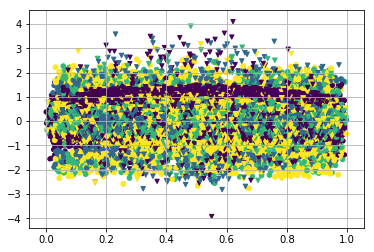

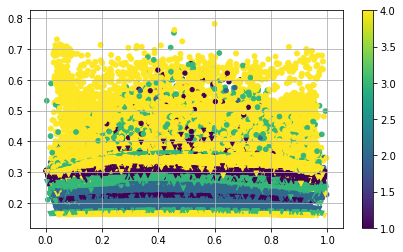

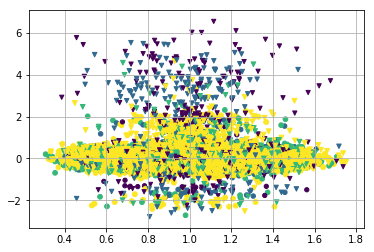

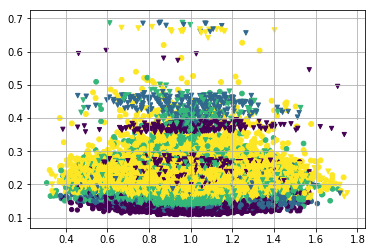

In [151]:
isS2s = np.ma.masked_where(np.logical_or.reduce((clus['sy']<3,clus['isBarrel']==0,clus['sx']!=2)),2*clus['layer']+16)
isS3s = np.ma.masked_where(np.logical_or.reduce((clus['sy']<3,clus['isBarrel']==0,clus['sx']!=3)),2*clus['layer']+16)
isS2l = np.ma.masked_where(np.logical_or.reduce((clus['sy']>2,clus['isBarrel']==0,clus['sx']!=2)),2*clus['layer']+16)
isS3l = np.ma.masked_where(np.logical_or.reduce((clus['sy']>2,clus['isBarrel']==0,clus['sx']!=3)),2*clus['layer']+16)

plt.scatter(clus['x'],clus['dx']+y_pred[:,0]/xw-clus['simSX'],s=isS2s,marker='o',c=clus['layer'])
plt.scatter(clus['x'],clus['dx']+y_pred[:,0]/xw-clus['simSX'],s=isS2l,marker='v',c=clus['layer'])
plt.grid()
plt.show()
plt.figure(figsize=(7, 4))
plt.scatter(clus['x'],s_pred[:,0],s=isS2s,marker='o',c=clus['layer'])
plt.scatter(clus['x'],s_pred[:,0],s=isS2l,marker='v',c=clus['layer'])
plt.colorbar()
plt.grid()
plt.show()
plt.scatter(clus['x'],clus['dx']+y_pred[:,0]/xw-clus['simSX'],s=isS3s,marker='o',c=clus['layer'])
plt.scatter(clus['x'],clus['dx']+y_pred[:,0]/xw-clus['simSX'],s=isS3l,marker='v',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(clus['x'],s_pred[:,0],s=isS3s,marker='o',c=clus['layer'])
plt.scatter(clus['x'],s_pred[:,0],s=isS3l,marker='v',c=clus['layer'])
plt.grid()
plt.show()

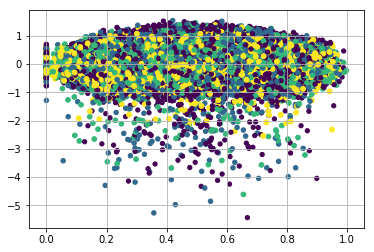

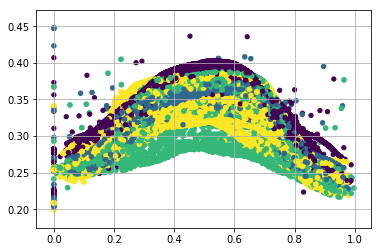

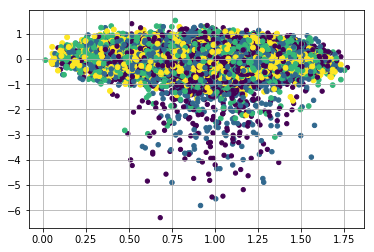

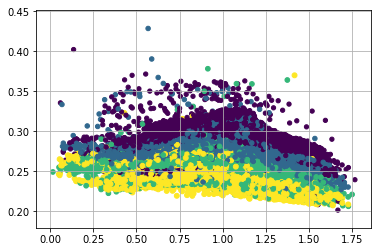

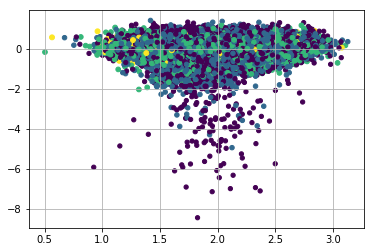

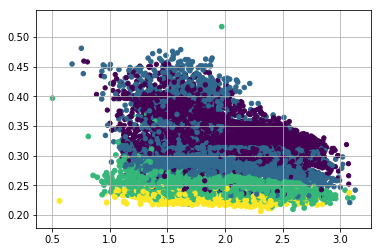

In [152]:
isS2 = np.ma.masked_where(np.logical_or(clus['isBarrel']==0,clus['sy']!=2),2*clus['layer']+16)
isS3 = np.ma.masked_where(np.logical_or(clus['isBarrel']==0,clus['sy']!=3),2*clus['layer']+16)
isS5 = np.ma.masked_where(np.logical_or(clus['isBarrel']==0,clus['sy']!=5),2*clus['layer']+16)

plt.scatter(clus['y'],clus['dy']+y_pred[:,1]-clus['simSY'],s=isS2,marker='o',c=clus['layer']+1)
plt.grid()
plt.show()
plt.scatter(clus['y'],s_pred[:,1],s=isS2,marker='o',c=clus['layer']+1)
plt.grid()
plt.show()
plt.scatter(clus['y'],clus['dy']+y_pred[:,1]-clus['simSY'],s=isS3,marker='o',c=clus['layer']+1)
plt.grid()
plt.show()
plt.scatter(clus['y'],s_pred[:,1],s=isS3,marker='o',c=clus['layer']+1)
plt.grid()
plt.show()
plt.scatter(clus['y'],clus['dy']+y_pred[:,1]-clus['simSY'],s=isS5,marker='o',c=clus['layer']+1)
plt.grid()
plt.show()
plt.scatter(clus['y'],s_pred[:,1],s=isS5,marker='o',c=clus['layer']+1)
plt.grid()
plt.show()
